In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("parkingLot.csv")
df

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

entries_df = df[df['camera_id'] == 1]

vehicles_per_day = entries_df.groupby('date')['vehicle_no'].nunique()
vehicles_per_day

date
2024-09-12     886
2024-09-13     809
2024-09-14     861
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     865
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Name: vehicle_no, Length: 63, dtype: int64

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MASE(actual, pred):
    n = len(actual)
    d = np.abs(np.diff(actual)).sum() / (n - 1)
    if d == 0:
        return np.inf 
    errors = np.abs(actual - pred).sum()
    return errors.mean() / d

<Axes: xlabel='date'>

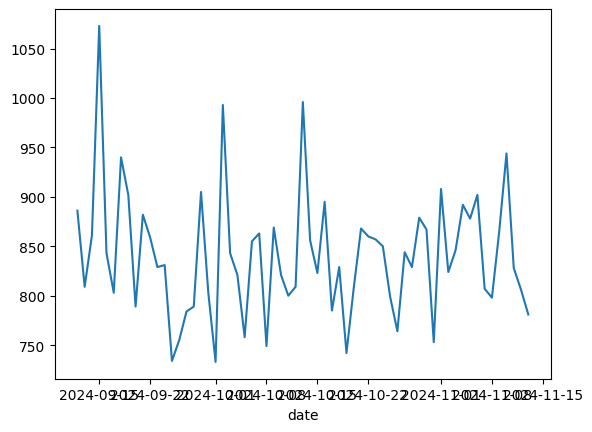

In [5]:
vehicles_per_day.plot(kind='line')

date
2024-09-12    886
2024-09-13    809
2024-09-14    861
2024-09-16    843
2024-09-17    803
Name: vehicle_no, dtype: int64

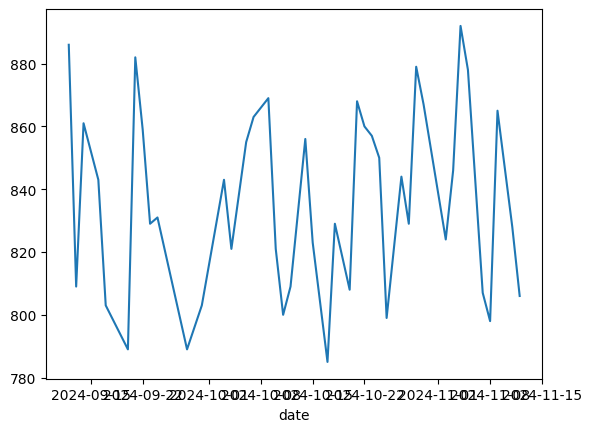

In [6]:
# do outlier smoothning in 2 different ways, first by removing them and another by replacing them with rolling mean values

# removing outliers
vehicles_per_day_no_outliers = vehicles_per_day[vehicles_per_day.between(vehicles_per_day.quantile(.15), vehicles_per_day.quantile(.85))]
vehicles_per_day_no_outliers.plot(kind='line')

vehicles_per_day_no_outliers.head()

C:\Users\vaibh\AppData\Local\Temp\ipykernel_29588\3957966821.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[         nan 887.85714286 890.14285714 832.28571429 811.28571429
 810.57142857 803.85714286 786.14285714 823.14285714 836.57142857
 840.28571429 843.85714286 857.14285714 846.57142857 829.42857143
 819.28571429 834.85714286 857.57142857 869.42857143 832.71428571]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vehicles_per_day_smoothed[(vehicles_per_day < lower_bound) | (vehicles_per_day > upper_bound)] = rolling_mean


date
2024-09-12    886.0
2024-09-13    809.0
2024-09-14    861.0
2024-09-16    843.0
2024-09-17    803.0
Name: vehicle_no, dtype: float64

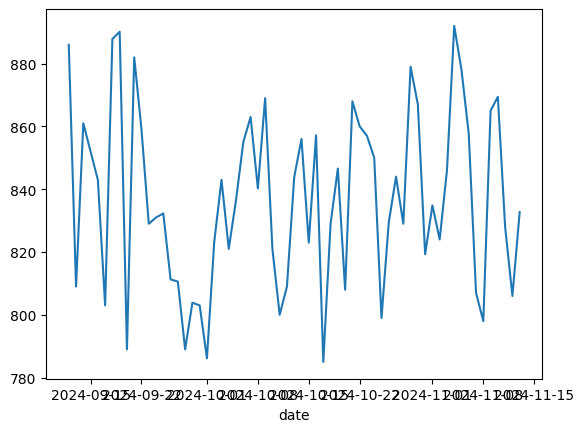

In [7]:
# Calculate the 15th and 85th percentiles
lower_bound = vehicles_per_day.quantile(0.15)
upper_bound = vehicles_per_day.quantile(0.85)

# Calculate the rolling mean
rolling_mean = vehicles_per_day.rolling(window=7).mean()

# Replace outliers with rolling mean
vehicles_per_day_smoothed = vehicles_per_day.copy()
vehicles_per_day_smoothed[(vehicles_per_day < lower_bound) | (vehicles_per_day > upper_bound)] = rolling_mean

# Drop NaN values resulting from rolling mean calculation
vehicles_per_day_smoothed = vehicles_per_day_smoothed.dropna()

# Plot the smoothed data
vehicles_per_day_smoothed.plot(kind='line')
vehicles_per_day_smoothed.head()

In [8]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

X = vehicles_per_day_no_outliers.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

In [9]:
history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
print(mean_absolute_error(test, predictions1))

28.111900858556155


In [10]:
print("MAPE: ", mean_absolute_percentage_error(test, predictions1))
print("MASE: ", MASE(test, predictions1))

MAPE:  3.3348692615365287
MASE:  7.027975214639039


In [11]:
X = vehicles_per_day_smoothed.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

In [12]:
history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
print(mean_absolute_error(test, predictions1))

22.16743467962615


In [13]:
print("MAPE: ", mean_absolute_percentage_error(test, predictions1))
print("MASE: ", MASE(test, predictions1))

MAPE:  2.622831957251859
MASE:  10.340383883020827


# B part

In [22]:
df = pd.read_csv("parkingLot.csv")
df.head()

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1


In [26]:
entries = df[df['camera_id'] == 1]
exits = df[df['camera_id'] == 2]

# remove nans from enteries and exits
entries = entries.dropna()
exits = exits.dropna()



In [30]:
paired_data = pd.merge(entries, exits, on='vehicle_no', suffixes=('_entry', '_exit'))
paired_data = paired_data[paired_data['timestamp_entry'] < paired_data['timestamp_exit']]
paired_data['timestamp_entry'] = pd.to_datetime(paired_data['timestamp_entry'])
paired_data['timestamp_exit'] = pd.to_datetime(paired_data['timestamp_exit'])
paired_data['duration'] = paired_data['timestamp_exit'] - paired_data['timestamp_entry']
paired_data['days'] = paired_data['duration'].dt.days
paired_data = paired_data[paired_data['days'] == 0]
paired_data = paired_data[paired_data['duration'] < pd.Timedelta('1 days')]
paired_data

,vehicle_no,timestamp_entry,camera_id_entry,timestamp_exit,camera_id_exit,duration,days
0,MHUN7063,2024-09-12 05:00:00,1,2024-09-12 08:00:00,2,0 days 03:00:00,0
1,MHYN4677,2024-09-12 05:00:00,1,2024-09-12 08:00:00,2,0 days 03:00:00,0
2,MHEL6595,2024-09-12 05:00:00,1,2024-09-12 08:00:00,2,0 days 03:00:00,0
3,MHNQ2590,2024-09-12 05:00:00,1,2024-09-12 08:20:00,2,0 days 03:20:00,0
4,MHGS9163,2024-09-12 05:00:00,1,2024-09-12 08:00:00,2,0 days 03:00:00,0
...,...,...,...,...,...,...,...
52755,MHVY8418,2024-11-13 20:00:00,1,2024-11-14 00:00:00,2,0 days 04:00:00,0
52756,MHDF3718,2024-11-13 20:00:00,1,2024-11-14 00:00:00,2,0 days 04:00:00,0
52757,MHQJ4009,2024-11-13 20:00:00,1,2024-11-14 00:00:00,2,0 days 04:00:00,0
52758,MHPN3450,2024-11-13 20:00:00,1,2024-11-14 00:00:00,2,0 days 04:00:00,0


In [41]:
# sort paired data with entry timestamp

paired_data = paired_data.sort_values(by='timestamp_entry')
paired_data['duration'] = paired_data['duration'].dt.seconds
paired_data

,vehicle_no,timestamp_entry,camera_id_entry,timestamp_exit,camera_id_exit,duration,days
0,MHUN7063,2024-09-12 05:00:00,1,2024-09-12 08:00:00,2,10800,0
5,MHJU1350,2024-09-12 05:00:00,1,2024-09-12 09:00:00,2,14400,0
8,MHBR3603,2024-09-12 05:00:00,1,2024-09-12 08:40:00,2,13200,0
7,MHZI0593,2024-09-12 05:00:00,1,2024-09-12 08:20:00,2,12000,0
6,MHYN8096,2024-09-12 05:00:00,1,2024-09-12 08:40:00,2,13200,0
...,...,...,...,...,...,...,...
52757,MHQJ4009,2024-11-13 20:00:00,1,2024-11-14 00:00:00,2,14400,0
52758,MHPN3450,2024-11-13 20:00:00,1,2024-11-14 00:00:00,2,14400,0
52755,MHVY8418,2024-11-13 20:00:00,1,2024-11-14 00:00:00,2,14400,0
52756,MHDF3718,2024-11-13 20:00:00,1,2024-11-14 00:00:00,2,14400,0


In [48]:
unpaired_data = df[~df['vehicle_no'].isin(paired_data['vehicle_no'])]
unpaired_data['duration'] = np.nan
unpaired_data = unpaired_data[unpaired_data['camera_id'] == 1]
unpaired_data = unpaired_data.drop(columns=['camera_id'])

entering_paired_df = paired_data[['vehicle_no', 'timestamp_entry', 'duration']]
entering_paired_df.columns = ['vehicle_no', 'timestamp', 'duration']

# merge the paired and unpaired data
final_df = pd.concat([entering_paired_df, unpaired_data])
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'])
final_df = final_df.sort_values(by='timestamp')
final_df


C:\Users\vaibh\AppData\Local\Temp\ipykernel_29588\805185436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unpaired_data['duration'] = 0


,vehicle_no,timestamp,duration
0,MHUN7063,2024-09-12 05:00:00,10800
16,MHDS3083,2024-09-12 05:00:00,19200
12,MHYM2116,2024-09-12 05:00:00,15600
13,MHNG3009,2024-09-12 05:00:00,18000
15,MHBL2555,2024-09-12 05:00:00,13200
...,...,...,...
52757,MHQJ4009,2024-11-13 20:00:00,14400
52758,MHPN3450,2024-11-13 20:00:00,14400
52755,MHVY8418,2024-11-13 20:00:00,14400
52756,MHDF3718,2024-11-13 20:00:00,14400


In [56]:
# now if final_df['duration] is 0, replace it with the duration of last record

final_df['duration'] = final_df['duration'].fillna(method='ffill')
final_df['duration'] = final_df['duration'].dropna()


C:\Users\vaibh\AppData\Local\Temp\ipykernel_29588\1922420440.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df['duration'] = final_df['duration'].fillna(method='ffill')


In [57]:
paired_data['date'] = paired_data['timestamp_entry'].dt.date
paired_data_days = paired_data.groupby('date')['duration'].mean()
paired_data_days

date
2024-09-12    15171.134021
2024-09-13    23300.751880
2024-09-14    29623.337223
2024-09-15    32234.366197
2024-09-16    30249.760766
                  ...     
2024-11-09    18554.063604
2024-11-10    17169.230769
2024-11-11    16861.689106
2024-11-12    17395.477387
2024-11-13    18724.675325
Name: duration, Length: 63, dtype: float64

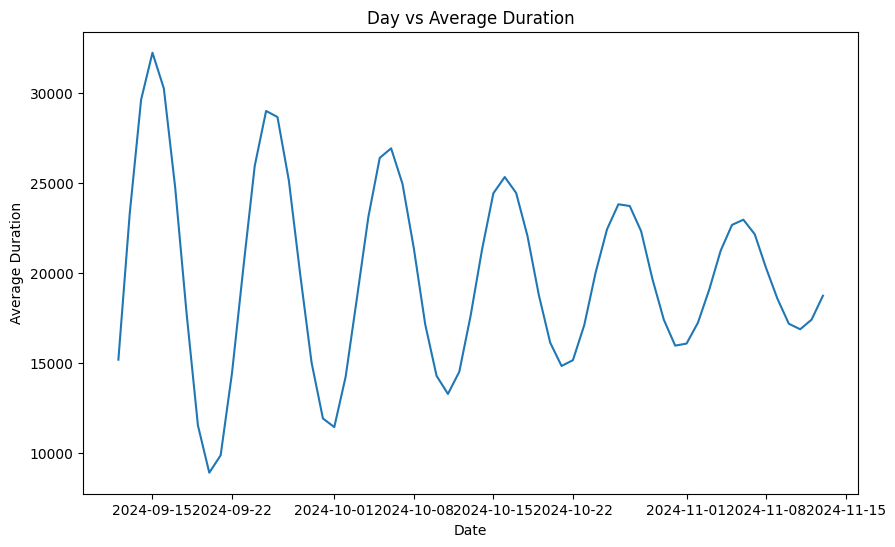

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(paired_data_days.index, paired_data_days.values)
plt.xlabel('Date')
plt.ylabel('Average Duration')
plt.title('Day vs Average Duration')
plt.show()

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(paired_data_days.values.reshape(-1, 1))
scaled_data = pd.DataFrame(scaled_values, columns=['duration'])
scaled_data.index = paired_data_days.index
scaled_data

,duration
date,
2024-09-12,0.269148
2024-09-13,0.617356
2024-09-14,0.888165
2024-09-15,1.000000
2024-09-16,0.914995
...,...
2024-11-09,0.414046
2024-11-10,0.354731
2024-11-11,0.341558


In [61]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

X = scaled_data.values
size = int(len(X) * 0.7)
train, test  = X[0:size], X[size:len(X)]

In [62]:
history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    temp  = output[0]
    predictions1.append(temp)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions1))


0.006976294328229254


In [63]:
unscaled_predictions = scaler.inverse_transform(np.array(predictions1).reshape(-1, 1))
unscaled_test = scaler.inverse_transform(test)

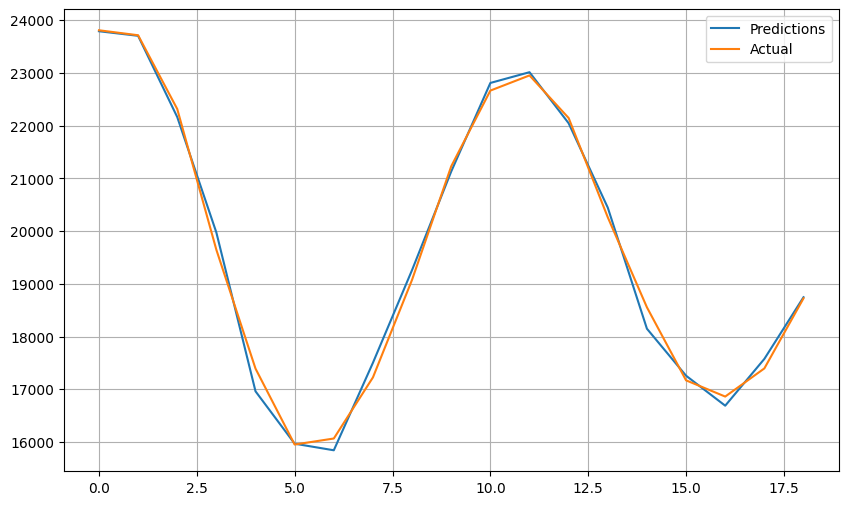

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(unscaled_predictions, label='Predictions')
plt.plot(unscaled_test, label='Actual')
plt.grid(True)
plt.legend()
plt.show()

In [66]:
print("MAPE: ", mean_absolute_percentage_error(unscaled_test, unscaled_predictions))
print("MASE: ", MASE(unscaled_test.reshape(1, -1)[0], unscaled_predictions.reshape(1, -1)[0]))

MAPE:  0.8739833870729281
MASE:  2.4419703125758416


In [69]:
final_df['date'] = final_df['timestamp'].dt.date
final_df_days = final_df.groupby('date')['duration'].mean()
final_df_days

date
2024-09-12    14948.532731
2024-09-13    22983.930779
2024-09-14    27475.324675
2024-09-15    31994.035415
2024-09-16    29998.576512
                  ...     
2024-11-09    17386.754967
2024-11-10    17023.728814
2024-11-11    16637.681159
2024-11-12    17179.652605
2024-11-13    18460.947503
Name: duration, Length: 63, dtype: float64

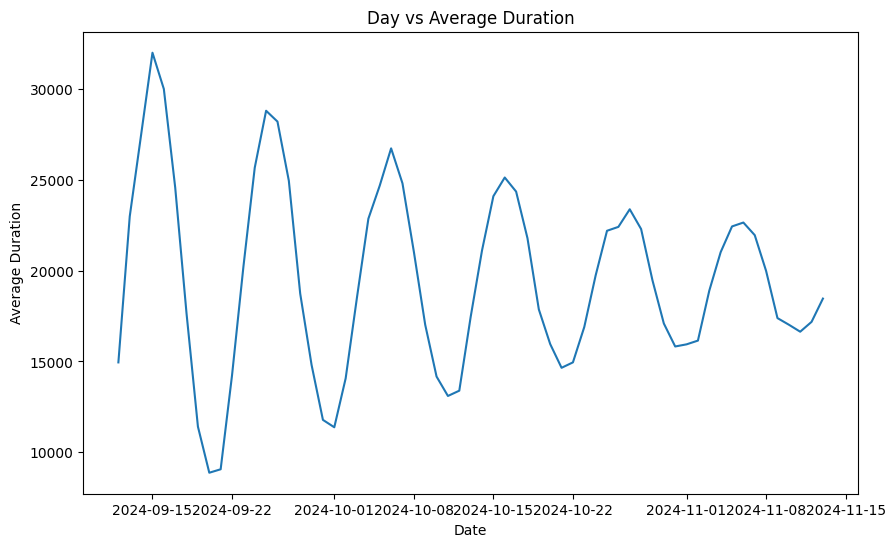

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(final_df_days.index, final_df_days.values)
plt.xlabel('Date')
plt.ylabel('Average Duration')
plt.title('Day vs Average Duration')
plt.show()

In [79]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(final_df_days.values.reshape(-1, 1))
scaled_data = pd.DataFrame(scaled_values, columns=['duration'])
scaled_data.index = final_df_days.index
scaled_data

,duration
date,
2024-09-12,0.262674
2024-09-13,0.610256
2024-09-14,0.804537
2024-09-15,1.000000
2024-09-16,0.913684
...,...
2024-11-09,0.368142
2024-11-10,0.352439
2024-11-11,0.335740


In [80]:
X = scaled_data.values
size = int(len(X) * 0.7)
train, test  = X[0:size], X[size:len(X)]

In [81]:
history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    temp  = output[0]
    predictions1.append(temp)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions1))

C:\Users\vaibh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\vaibh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.02686405763714425


In [82]:
unscaled_predictions = scaler.inverse_transform(np.array(predictions1).reshape(-1, 1))
unscaled_test = scaler.inverse_transform(test)

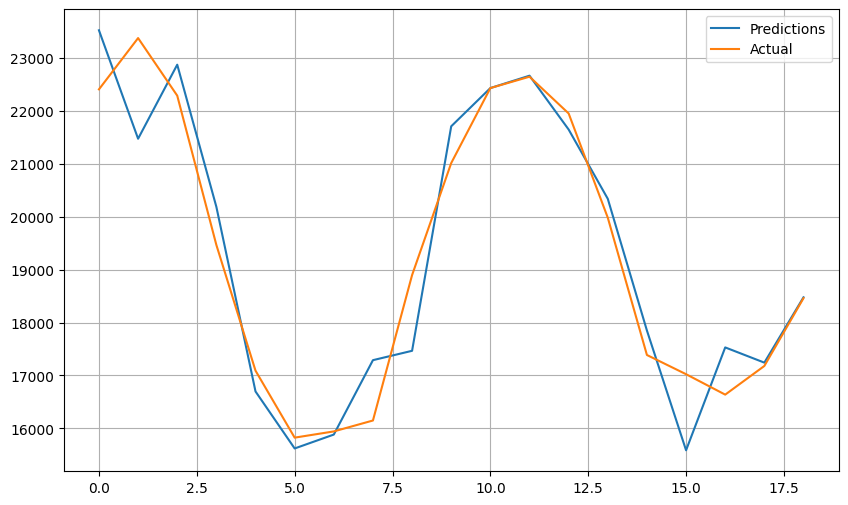

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(unscaled_predictions, label='Predictions')
plt.plot(unscaled_test, label='Actual')
plt.grid(True)
plt.legend()
plt.show()

In [84]:
print("MAPE: ", mean_absolute_percentage_error(unscaled_test, unscaled_predictions))
print("MASE: ", MASE(unscaled_test.reshape(1, -1)[0], unscaled_predictions.reshape(1, -1)[0]))

MAPE:  3.2385528898899203
MASE:  9.164238880320912
